In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math
import scipy.constants as sci
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
plt.rcParams["font.family"] = "Arial"
DPI = 300
Z = 22
TEMP = 310
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.4
from scipy.interpolate import Rbf
from sklearn.metrics import mean_squared_error

In [2]:
deg_pols = 21
Xini = 2.88
Xfin = 6.0

np_labels = ["N0", "N8", "N16", "N24", "N32", "N40", "N48", "N56", "N64", "N72", "N80", "N88", "N96", "N104"]
ion_labels = ["I0", "I10", "I20", "I50", "I90", "I150"]
q_vals = [0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104]
q_vals = np.array(q_vals)/21.24 #4pi(1.3)^2
center_q_vals = np.round((q_vals[1:][::2]+q_vals[:-1][::2])/2,1)
n_q_show = len(center_q_vals)
i_vals = [0, 30, 70, 170, 300, 500]
n_ion = len(i_vals)
n_np = len(q_vals)
c_np = cm.Blues(np.linspace(0.3, 1, len(np_labels)))
c_ion = cm.YlOrRd(np.linspace(0.3, 1, len(ion_labels)))
X = np.linspace(Xini, Xfin, 200)

In [3]:
def read_file(fname):
    f = open(fname, "r")
    fl = f.readlines()
    f.close()
    data = []
    for line in fl:
        if "#" not in line and "@" not in line:
            data.append(line.split())
    data = np.array(data, dtype = 'float')
    data = np.nan_to_num(data)
    return data

def ma(data, n):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(data, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=n:
            moving_ave = (cumsum[i] - cumsum[i-n])/n
            moving_aves.append(moving_ave)
    return moving_aves
    
def clean_pmf(pmf, new_space, fit=False, deg_pols=deg_pols):
    pmf[:,1] = pmf[:,1] - np.mean(pmf[-10:,1])
    if fit:
        pol_av = np.poly1d(np.polyfit(pmf[:,0], pmf[:,1], deg_pols))
        new_pmf = np.zeros((len(new_space),2))
        new_pmf[:,0] = new_space
        new_pmf[:,1] = pol_av(new_space)
    else:
        new_pmf = pmf*1
    return new_pmf

In [4]:
def hamaker(rs, n_density, sigma=0.47, epsilon=3.5, np_radius=1.3):
    #density in beads per nm3
    #sigma in nm
    #epsilon in kJ mol-1
    A = 4*np.pi**2*epsilon*(n_density*sigma**3)**2 #kJ/mol
    
    pre_att = -A/6
    pos_att = 2*np_radius**2/(rs**2-4*np_radius**2) + 2*np_radius**2/rs**2 + np.log((rs**2-4*np_radius**2)/rs**2)
    
    pre_rep = A*sigma**6/(37800*rs)
    pos_rep = (rs**2 - 14*np_radius*rs + 54*np_radius**2)*(1/(rs-2*np_radius)**7 + 1/(rs+2*np_radius)**7) - 2*(rs**2-30*np_radius**2)/rs**7
    return (pre_att*pos_att + pre_rep*pos_rep)/4.184

In [5]:
vdw_contribution = read_file("T2/PMF_L_ann/T2-N0-I0_L_PMF.xvg")
vdw_contribution = clean_pmf(vdw_contribution, X, fit=True)
vdw_contribution = vdw_contribution[:,1]

<ipython-input-5-c81b583c981b>:2: RankWarning: Polyfit may be poorly conditioned
  vdw_contribution = clean_pmf(vdw_contribution, X, fit=True)


In [6]:
popt, pcov = curve_fit(hamaker, X, vdw_contribution, p0=2)
best_density = popt[0]
ham_pot = hamaker(X, n_density=best_density)
diff_dimer = vdw_contribution[0]-ham_pot[0]
print("Best density: {:.2f} (sites nm-3)".format(best_density))
print("PMF dimerization energy: {:.2f} kcal mol-1".format(vdw_contribution[0]))
print("Hamaker dimerization energy: {:.2f} kcal mol-1".format(ham_pot[0]))
print("Difference in energy at contact: {:.2f} (kcal mol-1)".format(diff_dimer))

rms = math.sqrt(mean_squared_error(vdw_contribution, ham_pot))
print("RMSE: {:.2f} kcal mol-1".format(rms))

Best density: 26.45 (sites nm-3)
PMF dimerization energy: -28.64 kcal mol-1
Hamaker dimerization energy: -29.69 kcal mol-1
Difference in energy at contact: 1.05 (kcal mol-1)
RMSE: 1.60 kcal mol-1


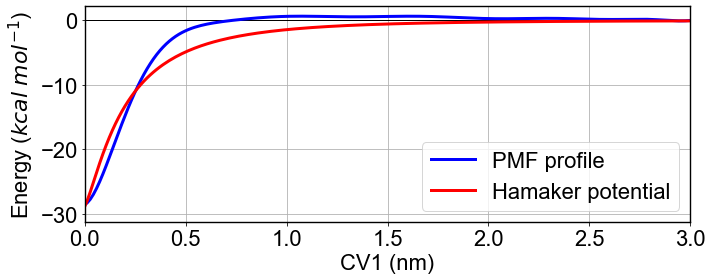

In [8]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
ax.tick_params(labelsize=Z)
ax.grid()
ax.set_xlabel("CV1 (nm)", fontsize=Z)
ax.set_ylabel(r"Energy ($kcal$ $mol^{-1}$)", fontsize=Z)
ax.axhline(0, c='k', lw=1)
ax.plot(X-2.9, vdw_contribution, c='b', lw=3, label='PMF profile')
ax.plot(X-2.9, hamaker(X, best_density), lw=3, c='r', label='Hamaker potential')
ax.set_xlim(0,3)
ax.legend(loc='lower right', fontsize=Z)
plt.tight_layout()
#plt.savefig("hamaker.png", format='png', dpi=DPI)
plt.show()
plt.close()

In [9]:
def full_hamaker(X, n_density):
    ham = hamaker(X, n_density=n_density)
    ham = np.append(np.flip(ham), ham)
    return ham

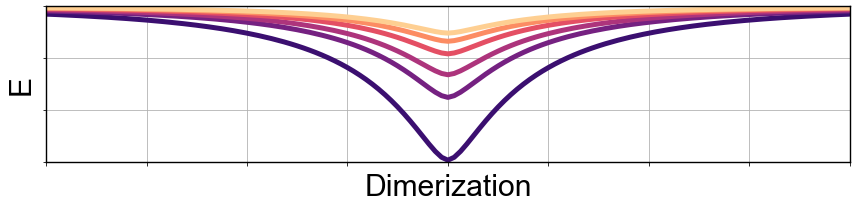

In [10]:
ham_factors = [1, 1.3, 1.5, 1.8, 2.1, 2.4]
c_ham = cm.magma(np.linspace(0.2, 0.9, len(ham_factors)))
all_space = np.append(-1*np.flip(X-2.88), X-2.88)
fig = plt.figure(figsize=(12,3))
ax = plt.axes()
ax.tick_params(labelsize=Z)
ax.grid()
ax.set_xlabel("Dimerization", fontsize=Z+8)
ax.set_ylabel(r"E", fontsize=Z+8)
ax.axhline(0, c='k', lw=1)
ax.set_xticklabels([])
ax.set_yticklabels([])
for factor, c in zip(ham_factors, c_ham):
    ham = full_hamaker(X, n_density=best_density/factor)
    ax.plot(all_space, ham, c=c, lw=5)
ax.set_xlim(-1, 1)
ax.set_ylim(-30, 0)
#ax.legend(loc='lower right', fontsize=Z)
plt.tight_layout()
plt.savefig("hamaker_toc.png", format='png', dpi=DPI)
plt.show()
plt.close()

In [11]:
PMFann = []
for np_lab in np_labels:
    pmfann_ion = []
    pmfann_ion_hist = []
    for ion_lab in ion_labels:
        pmfann = read_file("T2/PMF_L_ann/T2-{}-{}_L_PMF.xvg".format(np_lab, ion_lab))
        if np_lab=="N96" and ion_lab=="I90":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=9)
        if np_lab=="N104" and ion_lab=="I0":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=16)
        if np_lab=="N104" and ion_lab=="I10":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=12)
        if np_lab=="N104" and ion_lab=="I20":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=9)
        if np_lab=="N104" and ion_lab=="I50":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=9)
        if np_lab=="N104" and ion_lab=="I90":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=10)
        else:
            pmfann = clean_pmf(pmfann, X, fit=True)
        pmfann_ion.append(pmfann)

    PMFann.append(pmfann_ion)
PMFann = np.array(PMFann)
print(np.shape(PMFann))

(14, 6, 200, 2)


<ipython-input-11-37e5a39a3ef5>:20: RankWarning: Polyfit may be poorly conditioned
  pmfann = clean_pmf(pmfann, X, fit=True)
<ipython-input-11-37e5a39a3ef5>:20: RankWarning: Polyfit may be poorly conditioned
  pmfann = clean_pmf(pmfann, X, fit=True)
<ipython-input-11-37e5a39a3ef5>:20: RankWarning: Polyfit may be poorly conditioned
  pmfann = clean_pmf(pmfann, X, fit=True)
<ipython-input-11-37e5a39a3ef5>:20: RankWarning: Polyfit may be poorly conditioned
  pmfann = clean_pmf(pmfann, X, fit=True)
<ipython-input-11-37e5a39a3ef5>:20: RankWarning: Polyfit may be poorly conditioned
  pmfann = clean_pmf(pmfann, X, fit=True)
<ipython-input-11-37e5a39a3ef5>:20: RankWarning: Polyfit may be poorly conditioned
  pmfann = clean_pmf(pmfann, X, fit=True)
<ipython-input-11-37e5a39a3ef5>:20: RankWarning: Polyfit may be poorly conditioned
  pmfann = clean_pmf(pmfann, X, fit=True)
<ipython-input-11-37e5a39a3ef5>:20: RankWarning: Polyfit may be poorly conditioned
  pmfann = clean_pmf(pmfann, X, fit=True)


In [12]:
PMFann[9,1,:,1] = (PMFann[8,1,:,1]+PMFann[10,1,:,1])/2  #Interpolates N72-I10
PMFann[11,5,:,1] = (PMFann[10,5,:,1]+PMFann[12,5,:,1])/2 #Interpolates N88-I150
#PMFann[12,4,:,1] = (PMFann[11,4,:,1]+PMFann[13,4,:,1])/2 #Interpolates N96-I90

In [13]:
for i in range(len(PMFann)):
    for j in range(len(PMFann[0])):
        PMFann[i,j,:,1] = PMFann[i,j,:,1] - vdw_contribution

# Electrostatic contributions

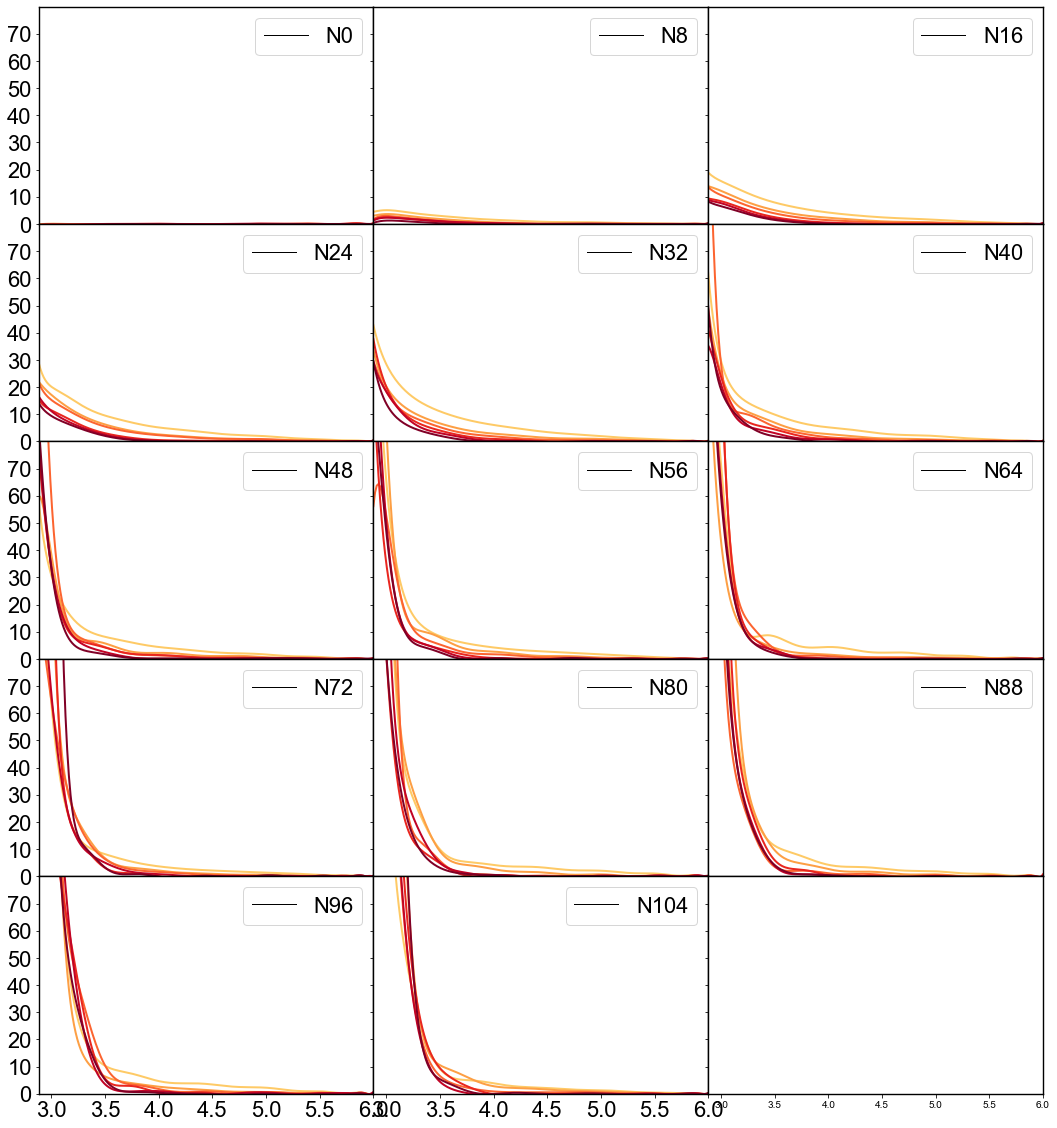

In [11]:
n_cols = 3
n_rows = 5
subplot_kw={'xlim':(Xini, Xfin), 'xticks':np.arange(3,6.1,0.5), 'ylim':(0, 80), 'yticks':np.arange(0, 80, 10)}
gridspec_kw={'hspace':0, 'wspace': 0}
fig, axs = plt.subplots(figsize=(6*n_cols, 4*n_rows), ncols=n_cols, nrows=n_rows, sharey=True, sharex=True, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw)
for ax, PMFs, np_lab in zip(axs.flatten(), PMFann, np_labels):
    ax.tick_params(labelsize=Z)
    ax.axhline(y=0, lw=1, c='k', label=np_lab)
    ax.legend(loc='upper right', fontsize=Z)
    for pmf, c in zip(PMFs, c_ion):
        ax.plot(pmf[:,0], pmf[:,1], color=c, lw=2)
plt.show()
plt.close()

# Phase diagrams

In [14]:
def build_agg_map_size(conc, np_radius, n_pts=500):
    x_start = 2*np_radius+0.28
    new_X = np.linspace(x_start, x_start+3.12, 200)
    xs = []
    ys = []
    fracs = []
    for i in range(n_ion):
        for j in range(n_np):
            pmf = PMFann[j,i,:,:]*1
            pmf[:,1] += hamaker(new_X, n_density=best_density, np_radius=np_radius)
            #pmf[:,1] += hamaker(new_X, n_density=436, np_radius=np_radius)
            
            ndx = np.argmin(pmf[pmf[:,0]-2*np_radius-0.52<0.7,1])
            dg_val = pmf[ndx,1]
            xs.append(j)
            ys.append(i)
            fracs.append(dimer_frac(dg_val, conc))
            
    #interpolation
    rbf = Rbf(xs, ys, fracs, epsilon=2)
    x = np.linspace(0, max(xs), n_pts)
    y = np.linspace(0, max(ys), n_pts)
    X_space, Y_space = np.meshgrid(x,y)
    Z = rbf(X_space, Y_space)
    return X_space, Y_space, Z

# Free energy maps

In [15]:
zeta_cont = np.loadtxt("contout3mV.csv", delimiter=',')

In [16]:
def build_dg_map_size(np_radius, n_pts=500):
    x_start = 2*np_radius+0.28
    new_X = np.linspace(x_start, x_start+3.12, 200)
    xs = []
    ys = []
    dgs = []
    for i in range(n_ion):
        for j in range(n_np):
            pmf = PMFann[j,i,:,:]*1
            pmf[:,1] += hamaker(new_X, n_density=best_density, np_radius=np_radius)
            #print(hamaker(new_X, n_density=best_density, np_radius=np_radius)[0])
            #pmf[:,1] += hamaker(new_X, n_density=436, np_radius=np_radius)
            
            ndx = np.argmin(pmf[pmf[:,0]-2*np_radius-0.52<0.7,1])
            dg_val = pmf[ndx,1]
            xs.append(j)
            ys.append(i)
            dgs.append(dg_val)
           
    dgs = np.array(dgs).reshape(6,14)
    dgs[4,9] = 0.66*dgs[4,8] + 0.33*dgs[4,11]
    dgs[4,10] = 0.33*dgs[4,8] + 0.66*dgs[4,11]
    dgs[3,4] = 0.5*(dgs[3,3] + dgs[3,5])+0.5
    dgs[5,10] = 0.5*(dgs[5,9] + dgs[5,11])
    dgs[2,8] = 0.5*dgs[2,7] + 0.5*dgs[2,9]
    dgs[2,11] = 0.5*dgs[2,10] + 0.5*dgs[2,12]
    dgs = dgs.flatten()

    #interpolation
    rbf = Rbf(xs, ys, dgs, epsilon=2)
    x = np.linspace(0, max(xs), n_pts)
    y = np.linspace(0, max(ys), n_pts)
    X_space, Y_space = np.meshgrid(x,y)
    Z = rbf(X_space, Y_space)
    return X_space, Y_space, Z

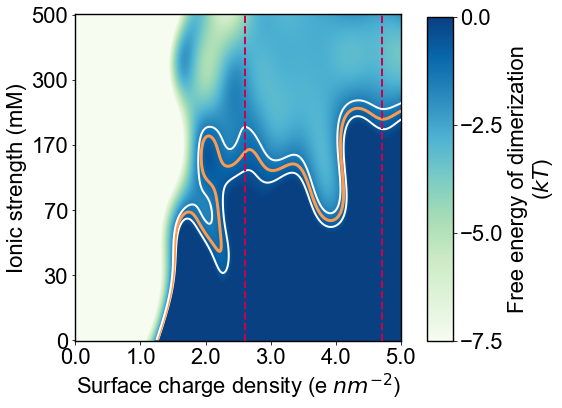

In [20]:
kT = 0.617
cmap='GnBu'
sx, sy, dg_map = build_dg_map_size(np_radius=1.3)
dg_map = dg_map/kT
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_xticks(np.linspace(0, len(dg_map)-1, 6))
#ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
ax.set_xticklabels(np.linspace(0,5,6))
ax.set_yticks(np.linspace(0, len(dg_map)-1, n_ion))
ax.set_yticklabels(i_vals)
ax.tick_params(labelsize=Z)
ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-7.5, vmax=0)
ax.axvline(len(dg_map)*2.6/5.0, lw=2, c=(0.8,0.0,0.3), zorder=10, ls='--')
ax.axvline(len(dg_map)*4.7/5.0, lw=2, c=(0.8,0.0,0.3), zorder=10, ls='--')
ax.contour(dg_map, levels=np.array([-0.5]), colors=[(1,1,1)], linewidths=[2], linestyles='-', zorder=10, origin='lower')
ax.contour(dg_map, levels=np.array([-1]), colors=[(1,0.6,0.3)], linewidths=[3], linestyles='-', zorder=10, origin='lower')
ax.contour(dg_map, levels=np.array([-1.5]), colors=[(1,1,1)], linewidths=[2], linestyles='-', zorder=10, origin='lower')

#ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=2, c='k', ls='--', zorder=20)

a = plt.axes([0.95, 0.125, 0.06, 0.75])
cbar = fig.colorbar(cax, ax=a, cax=a, ticks=np.linspace(-7.5,0,4))
cbar.ax.tick_params(labelsize=Z)
cbar.ax.set_ylabel("Free energy of dimerization\n"+r"($kT$)", fontsize=Z)
plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
plt.show()
plt.close()

# Free energy maps pseudo-size

# 2kT

In [22]:
def build_dg_map_implicit_2kT(np_radius, offset=0, n_pts=500):
    x_start = 2*np_radius+0.28
    new_X = np.linspace(x_start, x_start+3.12, 200)
    xs = []
    ys = []
    dgs = []
    for i in range(n_ion):
        for j in range(n_np):
            pmf = PMFann[j,i,:,:]*1
            pmf[:,1] += hamaker(new_X, n_density=best_density, np_radius=np_radius)
                    
            ndx = np.argmin(pmf[pmf[:,0]-2*np_radius-0.52<0.7,1])
            dg_val = pmf[ndx,1] + offset
            xs.append(j)
            ys.append(i)
            dgs.append(dg_val)
           
    dgs = np.array(dgs).reshape(6,14)
    dgs[4,9] = 0.66*dgs[4,8] + 0.33*dgs[4,11]
    dgs[4,10] = 0.33*dgs[4,8] + 0.66*dgs[4,11]
    dgs[3,4] = 0.5*(dgs[3,3] + dgs[3,5])+0.5
    dgs[5,10] = 0.5*(dgs[5,9] + dgs[5,11])
    dgs[2,8] = 0.5*dgs[2,7] + 0.5*dgs[2,9]
    dgs[2,11] = 0.5*dgs[2,10] + 0.5*dgs[2,12]
    dgs[1,8] = 0.5*dgs[1,7] + 0.5*dgs[1,9]
    dgs[0,8] = 0.5*dgs[0,7] + 0.5*dgs[0,9]
    dgs = dgs.flatten()

    #interpolation
    rbf = Rbf(xs, ys, dgs, epsilon=2)
    x = np.linspace(0, max(xs), n_pts)
    y = np.linspace(0, max(ys), n_pts)
    X_space, Y_space = np.meshgrid(x,y)
    Z = rbf(X_space, Y_space)
    return X_space, Y_space, Z

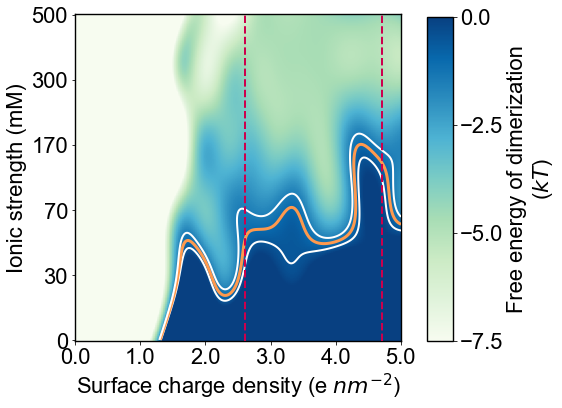

In [23]:
kT = 0.617
cmap='GnBu'
sx, sy, dg_map = build_dg_map_implicit_2kT(np_radius=1.3, offset=-2*kT)
dg_map = dg_map/kT
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_xticks(np.linspace(0, len(dg_map)-1, 6))
#ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
ax.set_xticklabels(np.linspace(0,5,6))
ax.set_yticks(np.linspace(0, len(dg_map)-1, n_ion))
ax.set_yticklabels(i_vals)
ax.tick_params(labelsize=Z)
ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-7.5, vmax=0)
ax.axvline(len(dg_map)*2.6/5.0, lw=2, c=(0.8,0.0,0.3), zorder=10, ls='--')
ax.axvline(len(dg_map)*4.7/5.0, lw=2, c=(0.8,0.0,0.3), zorder=10, ls='--')
ax.contour(dg_map, levels=np.array([-0.5]), colors=[(1,1,1)], linewidths=[2], linestyles='-', zorder=10, origin='lower')
ax.contour(dg_map, levels=np.array([-1]), colors=[(1,0.6,0.3)], linewidths=[3], linestyles='-', zorder=10, origin='lower')
ax.contour(dg_map, levels=np.array([-1.5]), colors=[(1,1,1)], linewidths=[2], linestyles='-', zorder=10, origin='lower')
#cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-5*kT, vmax=0)
#ax.contour(dg_map, levels=np.array([-0.5*kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.contour(dg_map, levels=np.array([-kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.contour(dg_map, levels=np.array([-1.5*kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.contour(dg_map, levels=np.array([-2*kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=2, c='k', ls='--', zorder=20)

a = plt.axes([0.95, 0.125, 0.06, 0.75])
cbar = fig.colorbar(cax, ax=a, cax=a, ticks=np.linspace(-7.5,0,4))
cbar.ax.tick_params(labelsize=Z)
cbar.ax.set_ylabel("Free energy of dimerization\n"+r"($kT$)", fontsize=Z)
plt.savefig("PhaseDiagram_Lann_offset2.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
plt.show()
plt.close()

# 4kT

In [24]:
def build_dg_map_implicit_4kT(np_radius, offset=-4*kT, n_pts=500):
    x_start = 2*np_radius+0.28
    new_X = np.linspace(x_start, x_start+3.12, 200)
    xs = []
    ys = []
    dgs = []
    for i in range(n_ion):
        for j in range(n_np):
            pmf = PMFann[j,i,:,:]*1
            pmf[:,1] += hamaker(new_X, n_density=best_density, np_radius=np_radius)
                    
            ndx = np.argmin(pmf[pmf[:,0]-2*np_radius-0.52<0.7,1])
            dg_val = pmf[ndx,1] + offset
            xs.append(j)
            ys.append(i)
            dgs.append(dg_val)
           
    dgs = np.array(dgs).reshape(6,14)
    dgs[4,9] = 0.66*dgs[4,8] + 0.33*dgs[4,11]
    dgs[4,10] = 0.33*dgs[4,8] + 0.66*dgs[4,11]
    dgs[3,4] = 0.5*(dgs[3,3] + dgs[3,5])+0.5
    dgs[5,10] = 0.5*(dgs[5,9] + dgs[5,11])
    dgs[2,8] = 0.5*dgs[2,7] + 0.5*dgs[2,9]
    dgs[2,11] = 0.5*dgs[2,10] + 0.5*dgs[2,12]
    dgs[0,8] = 0.5*dgs[0,7] + 0.5*dgs[0,9]
    dgs = dgs.flatten()

    #interpolation
    rbf = Rbf(xs, ys, dgs, epsilon=2)
    x = np.linspace(0, max(xs), n_pts)
    y = np.linspace(0, max(ys), n_pts)
    X_space, Y_space = np.meshgrid(x,y)
    Z = rbf(X_space, Y_space)
    return X_space, Y_space, Z

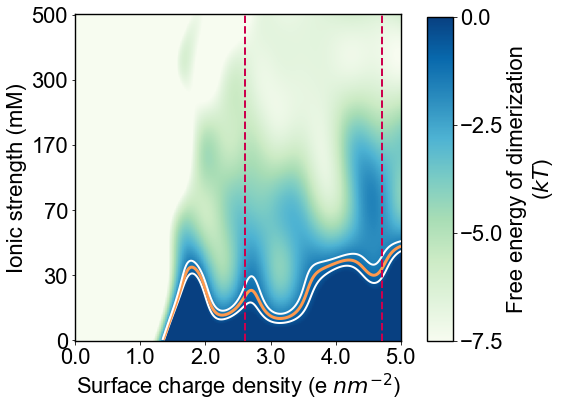

In [26]:
kT = 0.617
cmap='GnBu'
sx, sy, dg_map = build_dg_map_implicit_4kT(np_radius=1.3, offset=-4*kT)
dg_map = dg_map/kT
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_xticks(np.linspace(0, len(dg_map)-1, 6))
#ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
ax.set_xticklabels(np.linspace(0,5,6))
ax.set_yticks(np.linspace(0, len(dg_map)-1, n_ion))
ax.set_yticklabels(i_vals)
ax.tick_params(labelsize=Z)
ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-7.5, vmax=0)
ax.axvline(len(dg_map)*2.6/5.0, lw=2, c=(0.8,0.0,0.3), zorder=10, ls='--')
ax.axvline(len(dg_map)*4.7/5.0, lw=2, c=(0.8,0.0,0.3), zorder=10, ls='--')
ax.contour(dg_map, levels=np.array([-0.5]), colors=[(1,1,1)], linewidths=[2], linestyles='-', zorder=10, origin='lower')
ax.contour(dg_map, levels=np.array([-1]), colors=[(1,0.6,0.3)], linewidths=[3], linestyles='-', zorder=10, origin='lower')
ax.contour(dg_map, levels=np.array([-1.5]), colors=[(1,1,1)], linewidths=[2], linestyles='-', zorder=10, origin='lower')
#cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-5*kT, vmax=0)
#ax.contour(dg_map, levels=np.array([-0.5*kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.contour(dg_map, levels=np.array([-kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.contour(dg_map, levels=np.array([-1.5*kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.contour(dg_map, levels=np.array([-2*kT]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=2, c='k', ls='--', zorder=20)

a = plt.axes([0.95, 0.125, 0.06, 0.75])
cbar = fig.colorbar(cax, ax=a, cax=a, ticks=np.linspace(-7.5,0,4))
cbar.ax.tick_params(labelsize=Z)
cbar.ax.set_ylabel("Free energy of dimerization\n"+r"($kT$)", fontsize=Z)
plt.savefig("PhaseDiagram_Lann_offset4.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
plt.show()
plt.close()

# Size-Epsilon

In [20]:
C_files = ["T2/PMF_L_ann/T2-N0-I0_L_PMF.xvg", "T2/PMF_L_ann/T2-N0-I0_L_C01_PMF.xvg", "T2/PMF_L_ann/T2-N0-I0_L_C02_PMF.xvg"]
epsilons = [3.5, 4.5, 5.6]
hydrophobic = []
dg_hydro = []
for f in C_files:
    pmf = read_file(f)
    pmf = clean_pmf(pmf, X, fit=True)
    dg_hydro.append(pmf[np.argmin(pmf[:,1]),1])
    hydrophobic.append(pmf)
hydrophobic = np.array(hydrophobic)
print(np.shape(hydrophobic))
print(dg_hydro)

(3, 200, 2)
[-28.642698533833027, -37.798757925629616, -47.74208419024944]


C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned


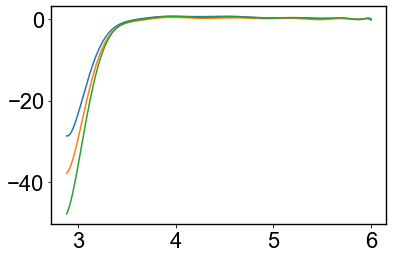

In [21]:
fig = plt.figure()
ax = plt.axes()
ax.tick_params(labelsize=Z)
for pmf in hydrophobic:
    ax.plot(pmf[:,0], pmf[:,1])
plt.show()
plt.close()

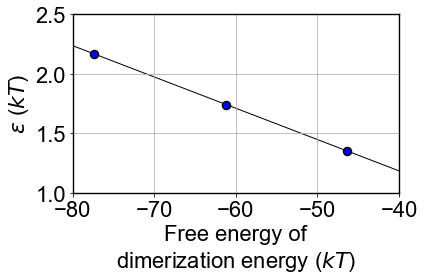

In [66]:
coeff = np.polyfit(dg_hydro, epsilons, 1)
reg = np.poly1d(coeff)
myspace = np.linspace(-53, -20, 20)

fig = plt.figure()
ax = plt.axes()
ax.set_xlabel("Free energy of\ndimerization energy "+r"($kT$)", fontsize=Z)
ax.set_ylabel(r"$\epsilon$ ($kT$)", fontsize=Z)
ax.set_ylim(1,2.5)
ax.set_xlim(-80,-40)
ax.set_yticks([1, 1.5, 2,2.5])
ax.tick_params(labelsize=Z)
ax.grid()
ax.plot(myspace/kT, reg(myspace)/(4.184*kT), color='k', linewidth=1, zorder=0)
ax.errorbar(np.array(dg_hydro)/kT, np.array(epsilons)/(4.184*kT), zorder=1, fmt='o', color='b', ms=8, mec='k', mew=1.5)
plt.tight_layout()
plt.savefig("eps-dimerization.png", format='png', dpi=300)
plt.show()
plt.close()

In [23]:
print(dg_hydro[0])
print(reg(dg_hydro[0])/(4.184*kT))

-28.642698533833027
1.3548832894445628


In [24]:
eps_2kt = reg(dg_hydro[0]-2*kT)/(4.184*kT)
eps_4kt = reg(dg_hydro[0]-4*kT)/(4.184*kT)
print(r"epsilon para decremento en 2kT: {:.3f} kJ/mol".format(eps_2kt))
print(r"epsilon para decremento en 4kT: {:.3f} kJ/mol".format(eps_4kt))

epsilon para decremento en 2kT: 1.407 kJ/mol
epsilon para decremento en 4kT: 1.460 kJ/mol


In [25]:
pearsonr(reg(dg_hydro), epsilons)

(0.999993183262771, 0.0023506265876515613)

# Atomistic Gold

In [26]:
def hamaker(rs, n_density, sigma=0.47, epsilon=3.5, np_radius=1.3):
    #density in beads per nm3
    #sigma in nm
    #epsilon in kJ mol-1
    A = 4*np.pi**2*epsilon*(n_density*sigma**3)**2 #kJ/mol
    
    pre_att = -A/6
    pos_att = 2*np_radius**2/(rs**2-4*np_radius**2) + 2*np_radius**2/rs**2 + np.log((rs**2-4*np_radius**2)/rs**2)
    
    pre_rep = A*sigma**6/(37800*rs)
    pos_rep = (rs**2 - 14*np_radius*rs + 54*np_radius**2)*(1/(rs-2*np_radius)**7 + 1/(rs+2*np_radius)**7) - 2*(rs**2-30*np_radius**2)/rs**7
    return (pre_att*pos_att + pre_rep*pos_rep)/4.184

In [27]:
np_rad_test = 25
X_temp = X-X[0]+0.15+2*np_rad_test
aa_hamaker = hamaker(X_temp, n_density=1.6492, np_radius=np_rad_test, sigma=0.2629, epsilon=22.1334)

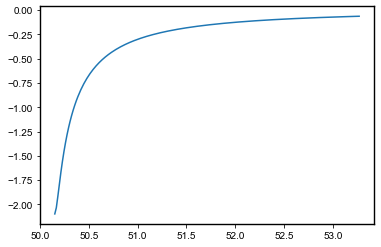

In [28]:
fig = plt.figure()
ax = plt.axes()
ax.plot(X_temp, aa_hamaker)

In [29]:
5.6/(0.617*4.184)

2.1692578968734795